# Digits
This is my notebook for playing around with the MNIST digits data set. The data set is a collection of $70000$, $28\times 28$ greyscale images of handwritten images. I treated the notebook as a live experimentation place, so only the final model which I thought worked the best was kept. 

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import random

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# one hot encode target values
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat  = tf.keras.utils.to_categorical(y_test)
# normalize xvalues
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

Now plot a few examples:

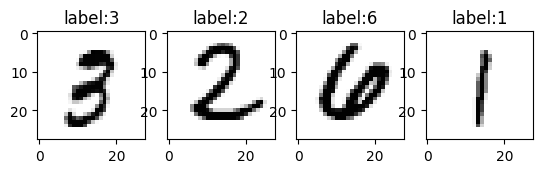

In [4]:
fig, axes = plt.subplots(1, 4)
for i, j in enumerate(random.sample(range(60000), 4)):
    axes[i].imshow(x_train[j], cmap='Greys')
    axes[i].set_title(f"label:{y_train[j]}")

In [5]:
# Build a sequential model. Since I will experiment with hyperparameter 
## optimization, encapsule this action into a function
tf.keras.backend.clear_session()
def create_uncompiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [7]:
tf.keras.backend.clear_session()
model = create_uncompiled_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,562 (224.85 KB)

 Trainable params: 57,562 (224.85 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * np.exp(-epoch/20))
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=10,
                                                           mode='auto',
                                                           restore_best_weights=True)
hist = model.fit(x_train, y_train_cat, 
                    epochs=50,
                    validation_split=0.1,
                    batch_size=64,
                    callbacks=[early_stopping_callback]
                   )

Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7837 - loss: 0.7195 - val_accuracy: 0.9730 - val_loss: 0.1057
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9647 - loss: 0.1230 - val_accuracy: 0.9823 - val_loss: 0.0648
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9777 - loss: 0.0789 - val_accuracy: 0.9848 - val_loss: 0.0514
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9827 - loss: 0.0581 - val_accuracy: 0.9860 - val_loss: 0.0462
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9859 - loss: 0.0480 - val_accuracy: 0.9892 - val_loss: 0.0429
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9885 - loss: 0.0401 - val_accuracy: 0.9875 - val_loss: 0.0438
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9896 - loss: 0.0351 - val_accuracy: 0.9883 - val_loss: 0.0472
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9907 - loss: 0.0317 - val_accuracy: 0.

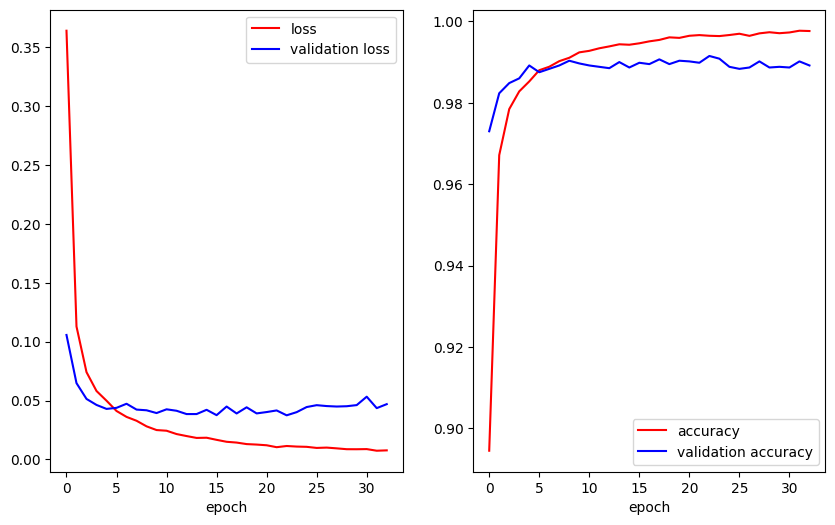

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10, 6), gridspec_kw={'hspace':0.2})
axes[0].plot(hist.history['loss'], color='red', label='loss')
axes[0].plot(hist.history['val_loss'], color='blue', label='validation loss')
axes[0].set_xlabel('epoch')
axes[0].legend(loc='best')
axes[1].plot(hist.history['accuracy'], color='red', label='accuracy')
axes[1].plot(hist.history['val_accuracy'], color='blue', label='validation accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(loc='best')

In [10]:
predictions = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [11]:
predictions[0]

array([1.02956185e-10, 9.59847171e-08, 1.80762534e-08, 9.98280747e-09,
       9.26755417e-13, 1.98883326e-10, 1.41744209e-15, 9.99999881e-01,
       3.04988001e-12, 4.75541206e-09], dtype=float32)

In [12]:
acc = tf.keras.losses.CategoricalCrossentropy()
accuracy = acc(y_test_cat, predictions).numpy()

In [13]:
indices_missed = []
for iy, ypred in enumerate(predictions):
    pred_label = np.argmax(ypred)
    if pred_label != y_test[iy]:
        print(f"predicted: {pred_label}, real: {y_test[iy]}")
        indices_missed.append(iy)


predicted: 5, real: 3
predicted: 7, real: 2
predicted: 3, real: 5
predicted: 0, real: 6
predicted: 5, real: 3
predicted: 2, real: 8
predicted: 6, real: 2
predicted: 1, real: 2
predicted: 7, real: 2
predicted: 9, real: 8
predicted: 5, real: 6
predicted: 6, real: 4
predicted: 2, real: 7
predicted: 4, real: 9
predicted: 5, real: 9
predicted: 7, real: 5
predicted: 3, real: 5
predicted: 7, real: 9
predicted: 5, real: 1
predicted: 7, real: 8
predicted: 6, real: 0
predicted: 5, real: 9
predicted: 1, real: 5
predicted: 3, real: 8
predicted: 4, real: 9
predicted: 7, real: 1
predicted: 3, real: 5
predicted: 9, real: 7
predicted: 0, real: 2
predicted: 0, real: 6
predicted: 9, real: 4
predicted: 1, real: 6
predicted: 6, real: 9
predicted: 1, real: 9
predicted: 4, real: 9
predicted: 5, real: 6
predicted: 4, real: 2
predicted: 3, real: 5
predicted: 2, real: 7
predicted: 1, real: 6
predicted: 9, real: 4
predicted: 0, real: 8
predicted: 5, real: 9
predicted: 5, real: 3
predicted: 5, real: 6
predicted:

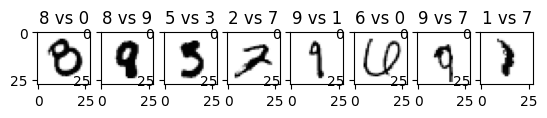

In [14]:
num_numbers = 8
fig, axes = plt.subplots(1, num_numbers)
for i, j in enumerate(random.sample(indices_missed, num_numbers)):
    prediction = np.argmax(predictions[j])
    axes[i].imshow(x_test[j], cmap='Greys')
    axes[i].set_title(f"{y_test[j]} vs {prediction}")

The accuracy on the test set is:

In [15]:
1. - len(indices_missed)/len(y_test)

0.9908

In [16]:
total_x = tf.concat([x_train, x_test], axis=0)
total_y = tf.concat([y_train_cat, y_test_cat], axis=0)

In [17]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                           patience=10,
                                                           mode='auto',
                                                           restore_best_weights=True)
final_hist = model.fit(total_x, total_y, 
                    epochs=40,
                    #validation_split=0.1,
                    batch_size=64,
                    callbacks=[early_stopping_callback]
                   )

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9929 - loss: 0.0233
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9938 - loss: 0.0195
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9952 - loss: 0.0151
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9961 - loss: 0.0148
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9961 - loss: 0.0127
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9967 - loss: 0.0110
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9969 - loss: 0.0101
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9959 - loss: 0.0120
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9962 - loss: 0.0114
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9959 - loss: 0.0109
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9971 - loss: 0.0092
Epoch 12/40
1094/1094 ━━━━

KeyboardInterrupt: 

In [20]:
model.save('./my_mnist_model.keras')